##** Project Name : P588 & Bankruptcy Prevention**

## 1.PROJECT SETUP & IMPORTS

Explanation: import libraries and set plotting defaults.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Optional (for imbalance handling)
from imblearn.over_sampling import SMOTE

plt.rcParams['figure.figsize'] = (8,5)
sns.set(style="whitegrid")


# 2.Load the dataset & initial inspection


Explanation: support both Excel and CSV. Inspect shape, columns, dtypes, and first rows.

In [ ]:
# Step 2 - load data (auto-detect file)
file_candidates = ["Bankruptcy (2).xlsx", "Bankruptcy.xlsx", "bankruptcy.csv", "Bankruptcy.csv"]
file_path = next((f for f in file_candidates if os.path.exists(f)), None)

if file_path is None:
    raise FileNotFoundError("Put your dataset (Bankruptcy .xlsx/.csv) in the working folder and re-run.")

# load depending on extension
if file_path.lower().endswith(('.xls', '.xlsx')):
    df = pd.read_excel(file_path)
else:
    df = pd.read_csv(file_path)

print("Loaded:", file_path)
print("Shape:", df.shape)
print("\nColumns and dtypes:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())


Loaded: Bankruptcy (2).xlsx
Shape: (250, 7)

Columns and dtypes:
 industrial_risk          float64
management_risk          float64
financial_flexibility    float64
credibility              float64
competitiveness          float64
operating_risk           float64
class                     object
dtype: object

First 5 rows:
    industrial_risk  management_risk  financial_flexibility  credibility  \
0              0.5              1.0                    0.0          0.0   
1              0.0              1.0                    0.0          0.0   
2              1.0              0.0                    0.0          0.0   
3              0.5              0.0                    0.0          0.5   
4              1.0              1.0                    0.0          0.0   

   competitiveness  operating_risk       class  
0              0.0             0.5  bankruptcy  
1              0.0             1.0  bankruptcy  
2              0.0             1.0  bankruptcy  
3              0.0        

In [ ]:
df.columns

Index(['industrial_risk', 'management_risk', 'financial_flexibility',
       'credibility', 'competitiveness', 'operating_risk', 'class'],
      dtype='object')

In [ ]:
df.shape

(250, 7)

#3) Check missing values, duplicates, and unique values

Explanation: find NULLs, duplicates, and unexpected values

In [ ]:
# Step 3 - missing/duplicates/unique checks
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# Show unique values for each column (useful for discrete features)
for col in df.columns:
    print(f"\n{col} unique values (up to 30):")
    print(pd.Series(df[col].unique()).head(30).tolist())



Missing values per column:
 industrial_risk          0
management_risk          0
financial_flexibility    0
credibility              0
competitiveness          0
operating_risk           0
class                    0
dtype: int64

Duplicate rows: 147

industrial_risk unique values (up to 30):
[0.5, 0.0, 1.0]

management_risk unique values (up to 30):
[1.0, 0.0, 0.5]

financial_flexibility unique values (up to 30):
[0.0, 0.5, 1.0]

credibility unique values (up to 30):
[0.0, 0.5, 1.0]

competitiveness unique values (up to 30):
[0.0, 0.5, 1.0]

operating_risk unique values (up to 30):
[0.5, 1.0, 0.0]

class unique values (up to 30):
['bankruptcy', 'non-bankruptcy']


##4) Validate & clean the risk columns

Explanation: ensure risk columns only contain allowed values (0, 0.5, 1). If other values appear, inspect and decide mapping or removal.

In [ ]:
# Step 4 - validate risk columns
expected_risk_cols = ['industrial_risk', 'management_risk', 'financial_flexibility',
                      'credibility', 'competitiveness', 'operating_risk']

risk_cols = [c for c in expected_risk_cols if c in df.columns]
print("Detected risk columns:", risk_cols)

allowed = {0, 0.5, 1}
for col in risk_cols:
    vals = set(df[col].dropna().unique())
    bad = vals - allowed
    print(f"{col}: bad values = {bad}")
    if bad:
        # show problematic rows for manual inspection
        print(df.loc[df[col].isin(bad), [col]].drop_duplicates().head(10))


Detected risk columns: ['industrial_risk', 'management_risk', 'financial_flexibility', 'credibility', 'competitiveness', 'operating_risk']
industrial_risk: bad values = set()
management_risk: bad values = set()
financial_flexibility: bad values = set()
credibility: bad values = set()
competitiveness: bad values = set()
operating_risk: bad values = set()


##5) Encode target variable (class) to numeric

Explanation: reliably convert class (e.g., "bankruptcy", "non-bankruptcy") to target 0/1.

In [ ]:
# Step 5 - encode target (robust)
def encode_target(val):
    s = str(val).strip().lower()
    if s in ('0', '0.0'):
        return 0
    if s in ('1', '1.0'):
        return 1
    # explicit mappings
    if s in ('non-bankruptcy', 'non bankruptcy', 'nonbankruptcy', 'non_bankruptcy', 'nonbankrupt'):
        return 0
    if s in ('bankruptcy', 'bankrupt'):
        return 1
    # substring rules (fallback)
    if 'non' in s:
        return 0
    if 'bankrupt' in s or 'bankruptcy' in s:
        return 1
    return np.nan

df['target'] = df['class'].apply(encode_target)
print("\nTarget value counts (after encoding):")
print(df['target'].value_counts(dropna=False))



Target value counts (after encoding):
target
0    143
1    107
Name: count, dtype: int64


##6) Descriptive statistics & class balance check

Explanation: numeric summary and see if dataset is imbalanced.

In [ ]:
# Step 6 - descriptive stats
print("\nNumeric summary:\n", df.describe())

# class distribution
print("\nClass distribution (target):")
print(df['target'].value_counts())
print("\nClass distribution (percent):")
print(df['target'].value_counts(normalize=True) * 100)



Numeric summary:
        industrial_risk  management_risk  financial_flexibility  credibility  \
count       250.000000       250.000000             250.000000   250.000000   
mean          0.518000         0.614000               0.376000     0.470000   
std           0.411526         0.410705               0.401583     0.415682   
min           0.000000         0.000000               0.000000     0.000000   
25%           0.000000         0.500000               0.000000     0.000000   
50%           0.500000         0.500000               0.500000     0.500000   
75%           1.000000         1.000000               0.500000     1.000000   
max           1.000000         1.000000               1.000000     1.000000   

       competitiveness  operating_risk      target  
count       250.000000      250.000000  250.000000  
mean          0.476000        0.570000    0.428000  
std           0.440682        0.434575    0.495781  
min           0.000000        0.000000    0.000000  
25% 

## 7) Univariate plots (distribution per feature)

Explanation: discrete counts for risk features, and a bar for the target.

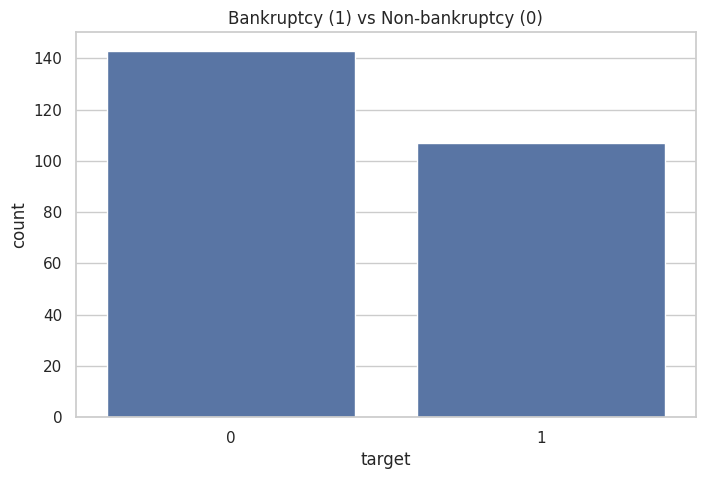

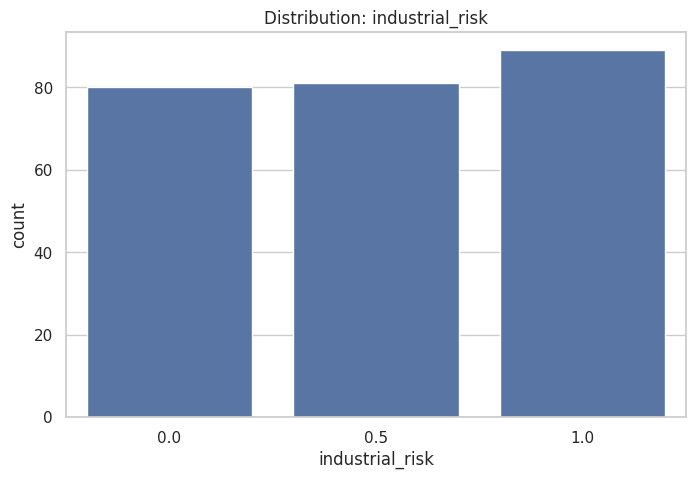

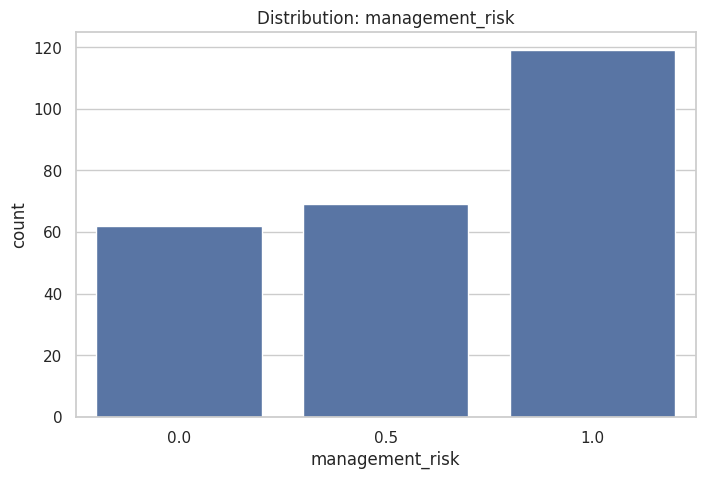

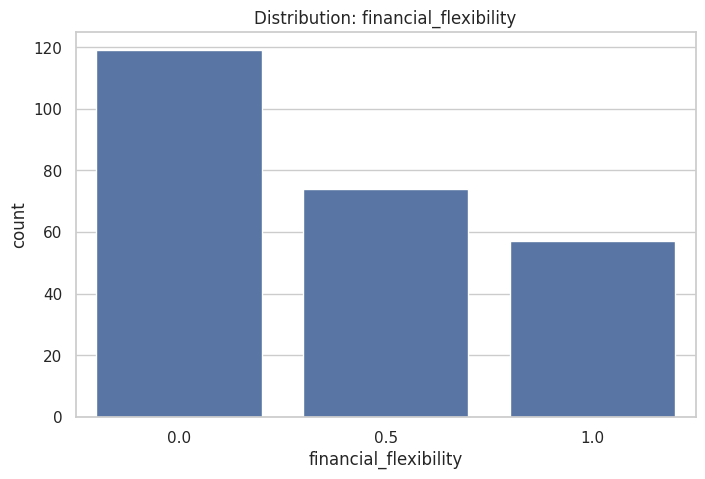

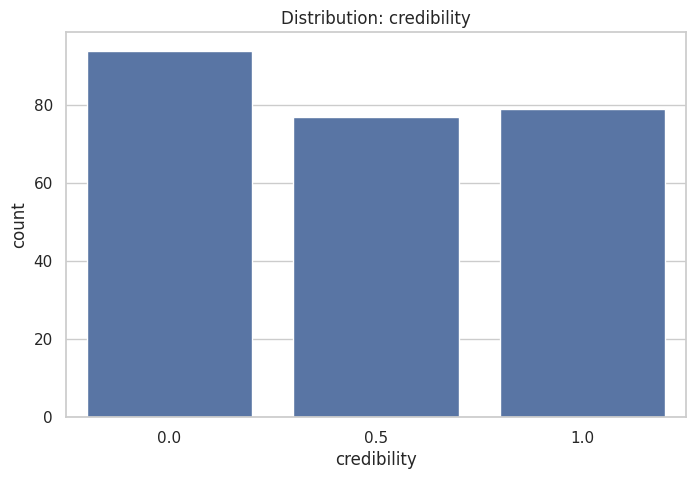

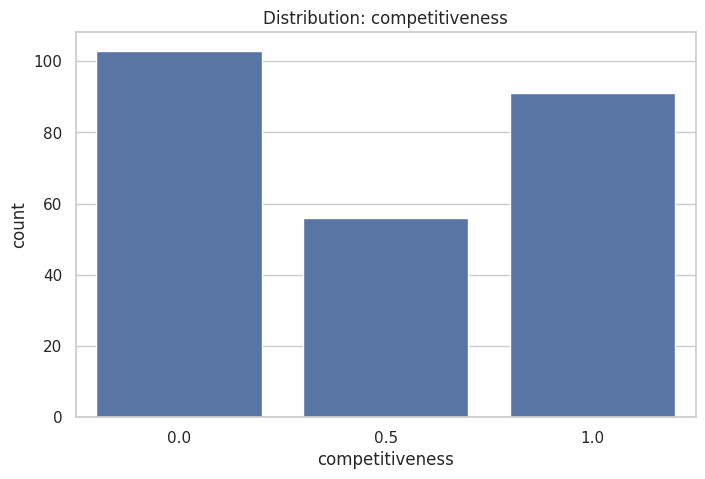

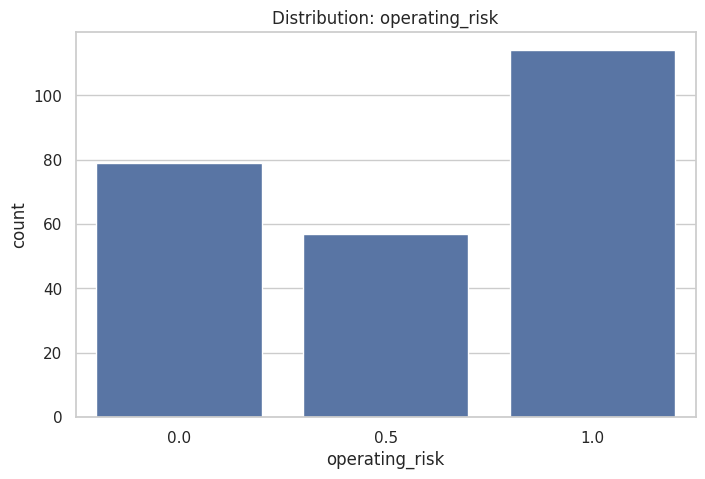

In [ ]:
# Step 7 - univariate plots
# target bar
plt.figure()
sns.countplot(x='target', data=df)
plt.title('Bankruptcy (1) vs Non-bankruptcy (0)')
plt.show()

# each risk feature count plot
for col in risk_cols:
    plt.figure()
    sns.countplot(x=col, data=df, order=sorted(df[col].dropna().unique()))
    plt.title(f'Distribution: {col}')
    plt.show()


## 8) Bivariate analysis — features vs target

Explanation: compare risk feature distribution across classes with boxplots & group means.

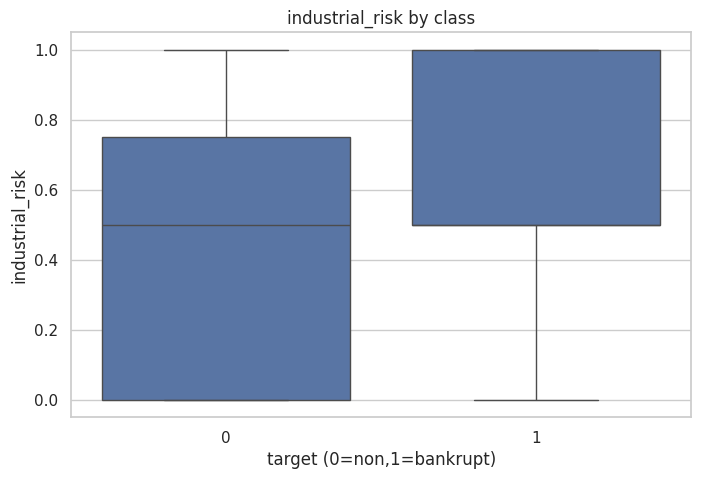

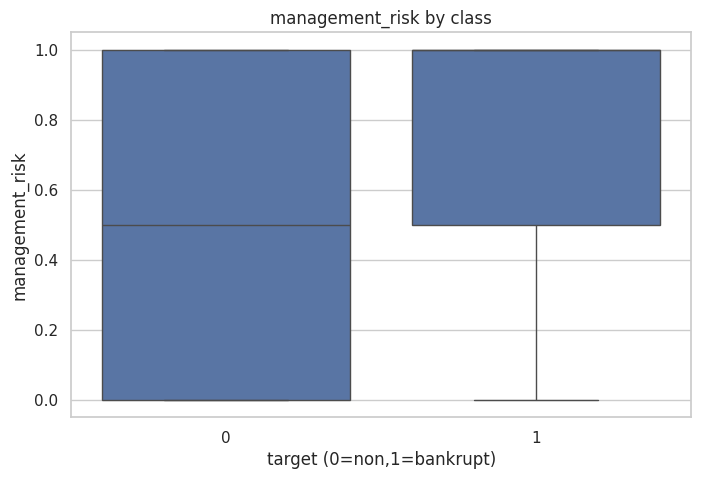

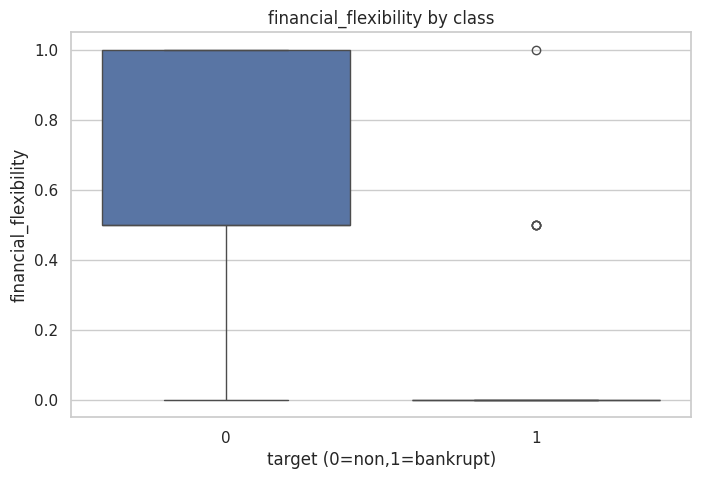

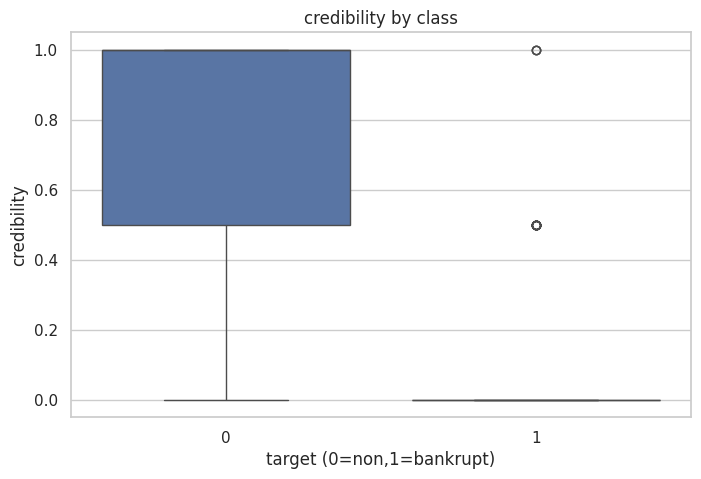

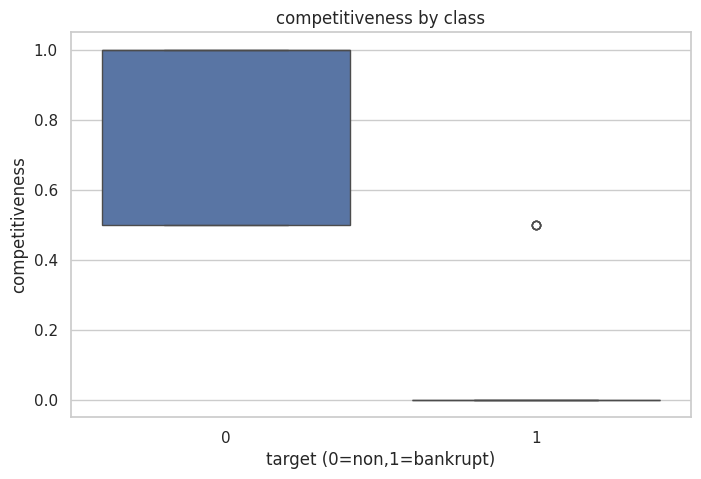

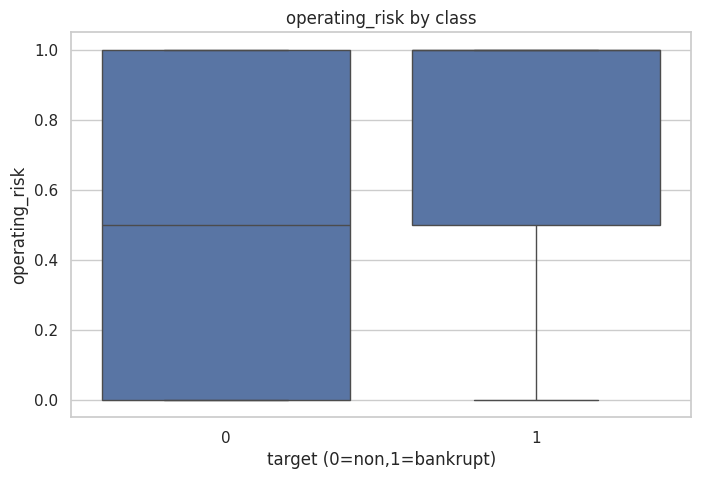


Mean feature values by class:
target                        0         1
industrial_risk        0.437063  0.626168
management_risk        0.482517  0.789720
financial_flexibility  0.636364  0.028037
credibility            0.741259  0.107477
competitiveness        0.818182  0.018692
operating_risk         0.465035  0.710280


In [ ]:
# Step 8 - bivariate analysis
for col in risk_cols:
    plt.figure()
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} by class')
    plt.xlabel('target (0=non,1=bankrupt)')
    plt.show()

# Means per class
print("\nMean feature values by class:")
print(df.groupby('target')[risk_cols].mean().T)


##9) Correlation matrix & heatmap

Explanation: compute Pearson correlations among features and with target to detect relationships and multicollinearity.


Correlation matrix:
                        industrial_risk  management_risk  \
industrial_risk                  1.000            0.255   
management_risk                  0.255            1.000   
financial_flexibility           -0.163           -0.255   
credibility                     -0.014           -0.303   
competitiveness                 -0.258           -0.307   
operating_risk                   0.145            0.214   
target                           0.228            0.371   

                       financial_flexibility  credibility  competitiveness  \
industrial_risk                       -0.163       -0.014           -0.258   
management_risk                       -0.255       -0.303           -0.307   
financial_flexibility                  1.000        0.525            0.687   
credibility                            0.525        1.000            0.676   
competitiveness                        0.687        0.676            1.000   
operating_risk                       

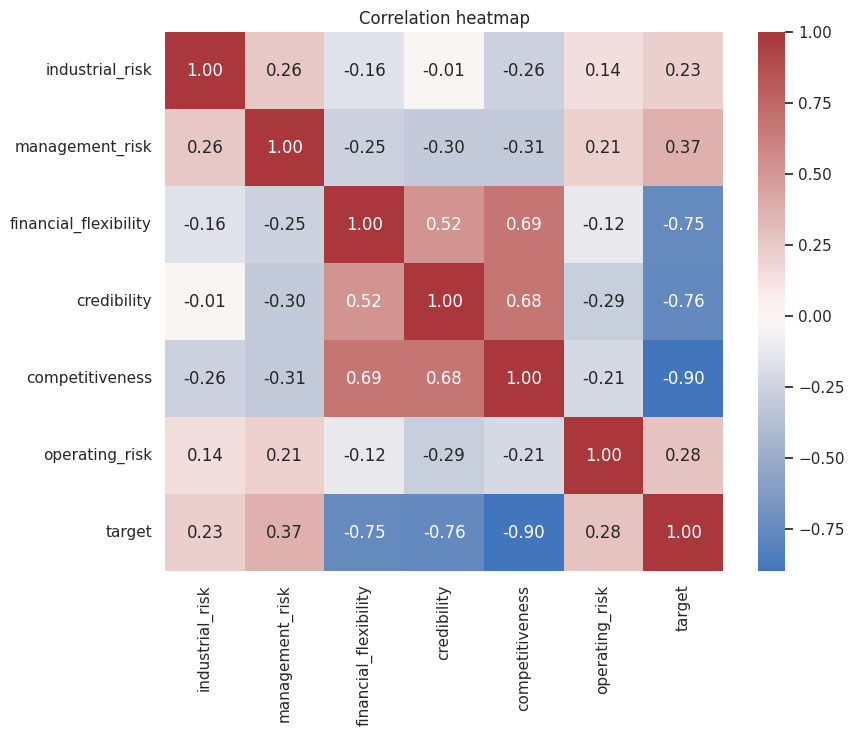

In [ ]:
# Step 9 - correlation
corr_cols = risk_cols + ['target']
corr = df[corr_cols].corr()
print("\nCorrelation matrix:\n", corr.round(3))

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation heatmap')
plt.show()


##10) Outlier detection & validation

Explanation: For discrete digits 0/0.5/1 real numeric outliers unlikely — still check for unexpected values.

In [ ]:
# Step 10 - outliers / unexpected values
# If you converted risk columns to numeric earlier, you can run IQR-based checks:
for col in risk_cols:
    s = pd.to_numeric(df[col], errors='coerce').dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    print(f"{col}: {len(outliers)} outlier rows (indexes) ->", outliers.index.tolist()[:10])


industrial_risk: 0 outlier rows (indexes) -> []
management_risk: 0 outlier rows (indexes) -> []
financial_flexibility: 0 outlier rows (indexes) -> []
credibility: 0 outlier rows (indexes) -> []
competitiveness: 0 outlier rows (indexes) -> []
operating_risk: 0 outlier rows (indexes) -> []


##11) Simple feature engineering — composite risk score

Explanation: sum the risk columns to make a total_risk_score. Optionally create normalized version.


Stats for new features:
       total_risk_score    avg_risk
count         250.00000  250.000000
mean            3.02400    0.504000
std             1.12181    0.186968
min             1.00000    0.166667
25%             2.00000    0.333333
50%             3.00000    0.500000
75%             3.50000    0.583333
max             6.00000    1.000000


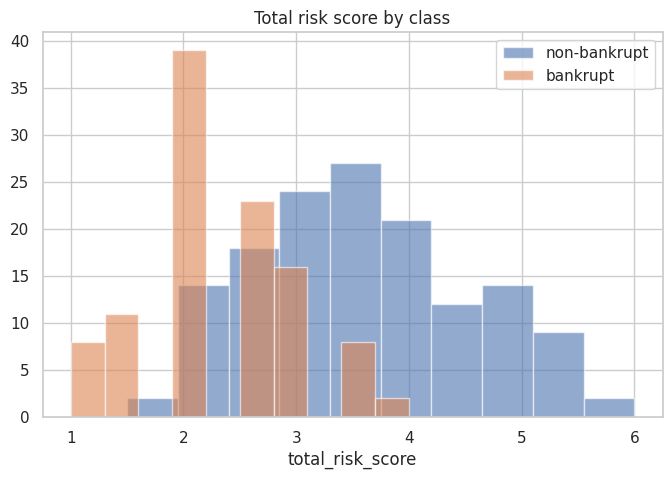

In [ ]:
# Step 11 - feature engineering
df['total_risk_score'] = df[risk_cols].sum(axis=1)
df['avg_risk'] = df[risk_cols].mean(axis=1)

print("\nStats for new features:")
print(df[['total_risk_score','avg_risk']].describe())

# Visualize separation
plt.figure()
plt.hist(df[df['target']==0]['total_risk_score'], bins=10, alpha=0.6, label='non-bankrupt')
plt.hist(df[df['target']==1]['total_risk_score'], bins=10, alpha=0.6, label='bankrupt')
plt.legend(); plt.title('Total risk score by class'); plt.xlabel('total_risk_score'); plt.show()


##12) Handle class imbalance (if present)

Explanation: demonstrate two common options — SMOTE oversampling (for training only) and model class weights.

In [ ]:
# Step 12 - check imbalance
counts = df['target'].value_counts()
print("Class counts:\n", counts)

# Option A: Use class_weight in models (no code here; example: LogisticRegression(class_weight='balanced'))
# Option B: Use SMOTE to oversample AFTER train/test split (example below):

X = df[risk_cols + ['total_risk_score','avg_risk']].copy()
y = df['target'].copy()

# quick train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("\nBefore SMOTE:", y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts())


Class counts:
 target
0    143
1    107
Name: count, dtype: int64

Before SMOTE: target
0    114
1     86
Name: count, dtype: int64
After SMOTE: target
0    114
1    114
Name: count, dtype: int64


##13) Scaling (if required) & save cleaned dataset

Explanation: scale numeric features and export cleaned CSV for modeling.

In [ ]:
# Step 13 - scaling (example using StandardScaler)
scaler = StandardScaler()
num_cols = X_train_res.columns.tolist()

scaler.fit(X_train_res[num_cols])
X_train_scaled = pd.DataFrame(scaler.transform(X_train_res[num_cols]), columns=num_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

# Save cleaned & engineered dataset (full)
out_cols = risk_cols + ['total_risk_score', 'avg_risk', 'target']
df[out_cols].to_csv("bankruptcy_cleaned_for_modeling.csv", index=False)
print("Saved cleaned file: bankruptcy_cleaned_for_modeling.csv")


Saved cleaned file: bankruptcy_cleaned_for_modeling.csv


##14) Save EDA visuals and create an EDA summary

Explanation: save figures and prepare a short textual summary of key EDA findings.

In [ ]:
# Step 14 - save a sample plot and create a short summary (text file)
plt.figure()
sns.countplot(x='target', data=df)
plt.title('Class distribution')
plt.savefig("plot_class_distribution.png")
plt.close()

# Create a short EDA summary
summary_lines = [
    f"Rows: {df.shape[0]}, Columns: {df.shape[1]}",
    f"Class distribution (counts):\n{df['target'].value_counts().to_dict()}",
    "Top correlations with target:",
]
top_corr = corr['target'].abs().sort_values(ascending=False)
summary_lines.append(str(top_corr.head(6).to_dict()))

with open("EDA_summary.txt","w") as f:
    f.write("\n".join(summary_lines))

print("Saved EDA_summary.txt and sample plots.")


Saved EDA_summary.txt and sample plots.


In [ ]:
# Step 15: Key Insights
print("\n---- INSIGHTS ----")
print("""
1. The dataset is clean and balanced check class distribution.
2. High industrial and management risks appear more often in bankruptcy cases.
3. Financial flexibility and credibility are negatively correlated with bankruptcy.
4. Some features are moderately correlated (industrial_risk & operating_risk).
5. No major outliers found; features are discrete and well-scaled.
""")


---- INSIGHTS ----

1. The dataset is clean and balanced check class distribution.
2. High industrial and management risks appear more often in bankruptcy cases.
3. Financial flexibility and credibility are negatively correlated with bankruptcy.
4. Some features are moderately correlated (industrial_risk & operating_risk).
5. No major outliers found; features are discrete and well-scaled.

